In [11]:
import re
import math
import torch
import matplotlib.pyplot as plt

from models import LSTMModel, GRUModel, TCNModel
from preprocessing import load_group, SlidingWindowDataset, apply_transformations
from training import evaluate_model

import config as cfg


In [12]:
MODE, TRAINED_KEYS = "house", ["MAC000246"]
#MODE, TRAINED_KEYS = "block", [0]

EVALUATION_HORIZONS = [1, 90, 390]   # 1 day, 90 days, 13 months (390 days)

MODEL_NAME_TO_CLASS = {
    "LSTMModel": LSTMModel,
    "GRUModel": GRUModel,
    "TCNModel": TCNModel,
}

In [13]:
def discover_model_files(mode, keys):
    pattern = re.compile(r"^(LSTMModel|GRUModel|TCNModel)_" + re.escape(mode) + r"_(.+)\.pt$")
    found = {}

    # If keys is provided, build a reverse lookup from str(key) → original key
    key_map = {str(k): k for k in keys} if keys else None

    for p in cfg.OUTMODELS_DIR.glob("*.pt"):
        m = pattern.match(p.name)
        if not m:
            continue
        key_str = m.group(2)

        # If keys is provided, check if key_str is in the map
        if key_map is not None:
            if key_str not in key_map:
                continue
            original_key = key_map[key_str]
        else:
            original_key = key_str

        found.setdefault(original_key, []).append(p)

    return found

In [14]:
files_by_key = discover_model_files(MODE, TRAINED_KEYS)

summary_rows = []

for key, paths in files_by_key.items():
    print(f"\n Starting evaluation for key: {key}")
    df_group = load_group(MODE, key, str(cfg.PICKLE_BLOCK), str(cfg.PICKLE_HOUSE))

    for path in paths: 
        m = re.match(r"^(LSTMModel|GRUModel|TCNModel)_" + re.escape(MODE) + r"_", path.name)
        if not m:
            continue
        model_name = m.group(1)

        artifact = torch.load(path, map_location="cpu", weights_only=False)

        # build list of available trained horizons from artifact
        available_horizons = []
        for k in artifact.keys():
            hz_m = re.match(r"^horizon_(\d+)$", k)
            if hz_m:
                available_horizons.append(int(hz_m.group(1)))

        for eval_horizon in EVALUATION_HORIZONS:
            
            valid_horizons = [h for h in available_horizons if eval_horizon % h == 0]
            if not valid_horizons:
                raise ValueError(
                    f"No available model horizon divides evaluation_horizon={eval_horizon}. "
                    f"Available: {available_horizons}"
                )
            # Pick the horizon that minimizes rollouts (eval_horizon / h)
            best_hz = min(valid_horizons, key=lambda h: eval_horizon // h)

            info = artifact.get(f"horizon_{best_hz}")
            if info is None:
                continue

            config = info["config"]
            tscaler = info["scalers"]
            features = info.get("features", ["DOY"])

            # Important: compute final_features once so we know input_size
            df_scaled, final_features = apply_transformations(
                df_group, cfg.TARGET, cfg.LAGS, features, tscaler
            )

            # Build the model for the selected trained horizon (best_hz)
            cls = MODEL_NAME_TO_CLASS[model_name]
            model = cls(
                input_size=len(final_features),
                horizon=best_hz,
                **{k: config[k] for k in cls.REQUIRED_KEYS}
            )
            model.load_state_dict(info["model_state_dict"])
            model.eval()

            window_size = config.get("window_size", best_hz)
            full_ds = SlidingWindowDataset(df_scaled, window_size, best_hz, final_features, cfg.TARGET, cfg.LAGS)

            # -----------------------------------------------------
            # Case A: direct evaluation (eval_horizon == best_hz)
            # -----------------------------------------------------
            if eval_horizon == best_hz:
                preds_t, targets_t = evaluate_model(model, full_ds)

                mse_eval = torch.mean((preds_t - targets_t) ** 2).item()
                rmse_eval = math.sqrt(mse_eval)
                print(f"Direct evaluation with {model_name} at horizon {best_hz}: {len(full_ds)} windows, RMSE: {rmse_eval:.4f}")

                row = {
                    "key": key,
                    "model": model_name,
                    "trained_horizon": best_hz,
                    "evaluation_horizon": eval_horizon,
                    "reeval_rmse": rmse_eval,
                }
                summary_rows.append(row)

            # -----------------------------------------------------
            # Case B: recursive evaluation (eval_horizon > best_hz)
            # Example: eval_horizon=390, best_hz=30 → shift=30, repeat 13 times
            # -----------------------------------------------------
            elif eval_horizon > best_hz:
                total_preds, total_targets = [], []

                n_shifts = eval_horizon // best_hz
                for step in range(n_shifts):
                    # take the "first" window each time
                    X, y = full_ds[0]
                    with torch.no_grad():
                        preds = model(X.unsqueeze(0)).squeeze(0).cpu()

                    # collect predictions & true targets
                    total_preds.append(preds)
                    total_targets.append(y)

                    # roll forward by horizon steps
                    full_ds.roll_forward(preds.numpy(), shift=best_hz)

                preds_t = torch.cat(total_preds, dim=0)
                targets_t = torch.cat(total_targets, dim=0)

                mse_eval = torch.mean((preds_t - targets_t) ** 2).item()
                rmse_eval = math.sqrt(mse_eval)
                print(f"Recursive evaluation with {model_name}: eval_horizon {eval_horizon} using horizon {best_hz}, RMSE: {rmse_eval:.4f}")

                row = {
                    "key": key,
                    "model": model_name,
                    "trained_horizon": best_hz,
                    "evaluation_horizon": eval_horizon,
                    "reeval_rmse": rmse_eval,
                }
                summary_rows.append(row)


 Starting evaluation for key: MAC000246
Direct evaluation with GRUModel at horizon 1: 728 windows, RMSE: 0.1252
Direct evaluation with GRUModel at horizon 90: 550 windows, RMSE: 0.1346
Recursive evaluation with GRUModel: eval_horizon 390 using horizon 30, RMSE: 0.1434
Direct evaluation with LSTMModel at horizon 1: 728 windows, RMSE: 0.1266
Direct evaluation with LSTMModel at horizon 90: 550 windows, RMSE: 0.1339
Recursive evaluation with LSTMModel: eval_horizon 390 using horizon 30, RMSE: 0.1582
Direct evaluation with TCNModel at horizon 1: 728 windows, RMSE: 0.1253
Direct evaluation with TCNModel at horizon 90: 550 windows, RMSE: 0.1448
Recursive evaluation with TCNModel: eval_horizon 390 using horizon 30, RMSE: 0.1087


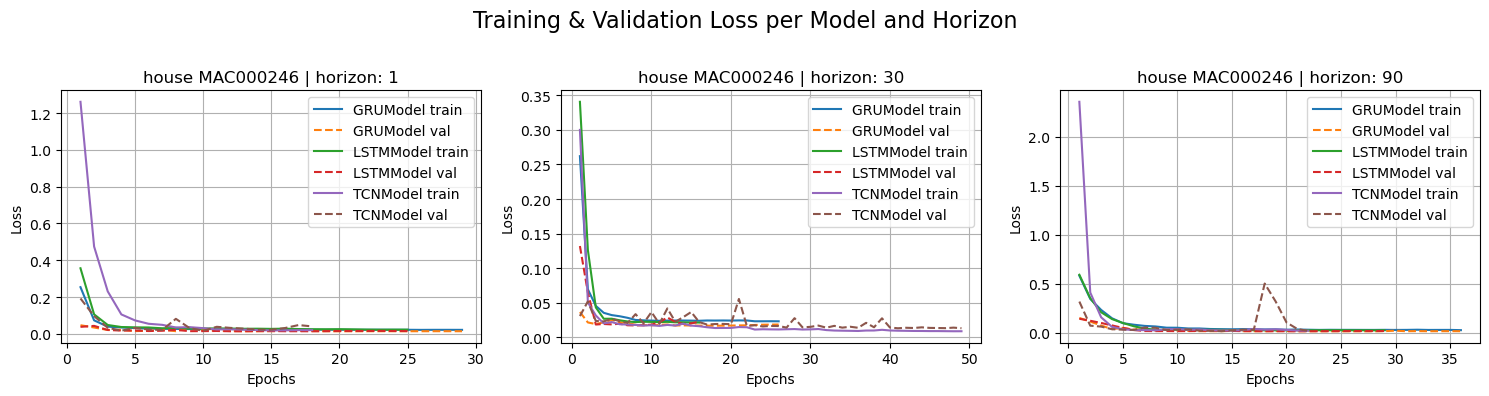

In [15]:
# Collect all horizons across all artifacts for consistent column ordering
all_horizons = sorted({hz for paths in files_by_key.values() for path in paths 
                       for hz in torch.load(path, map_location="cpu", weights_only=False).keys()
                       if hz.startswith("horizon_")})

n_rows = len(TRAINED_KEYS)
n_cols = len(all_horizons)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), squeeze=False)
fig.suptitle("Training & Validation Loss per Model and Horizon", fontsize=16)

for i, key in enumerate(TRAINED_KEYS):
    paths = files_by_key.get(key, [])
    for j, hz_key in enumerate(all_horizons):
        ax = axes[i, j]

        for path in paths:
            artifact = torch.load(path, map_location="cpu", weights_only=False)
            # check if this horizon exists
            info = artifact.get(hz_key)
            if info is None:
                continue

            model_name = path.name.split("_")[0]  # e.g. "LSTMModel", "GRUModel"

            train_loss = info.get("train_loss")
            val_loss = info.get("val_loss")
            epochs = range(1, len(train_loss)+1)

            if train_loss is not None and val_loss is not None:
                ax.plot(epochs, train_loss, label=f"{model_name} train")
                ax.plot(epochs, val_loss, '--', label=f"{model_name} val")

        ax.set_title(f"{MODE} {key} | horizon: {hz_key.replace('horizon_', '')}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")
        ax.legend()
        ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()